### Decision Trees

We will now go through a concrete example and build a decision tree for the Titanic dataset using Scikit-learn.

###### Data preprocessing
Let’s start by loading the data from the c4_titanic.csv file.

In [1]:
import pandas as pd

# Load data
data_df = pd.read_csv("c4_titanic.csv")

# First five rows
data_df.head()

,name,pclass,age,sex,survived
0,"Hirvonen, Miss Hildur E",3rd,2,female,0
1,"Van Impe, Miss Catharine",3rd,10,female,0
2,"Sjostedt, Mr Ernst Adolf",2nd,59,male,0
3,"Fortune, Mr Mark",1st,64,male,0
4,"Ware, Mr William J",2nd,23,male,0


The data contains five variables. 
* name of the passenger
* its class
* age 
* sex
* the target variable indicates if the passenger survived.

Scikit-learn cannot work directly on this DataFrame to build the decision tree, but we can convert it into the usual X/y Numpy arrays by encoding categories with numerical values. We will use a simple 0/1 encoding for the binary sex feature and one-hot encoding for the pclass variable which has three possible values.



In [2]:
# One-hot encoding
encoded_df = pd.get_dummies(data_df, columns=["pclass"])

# Encode binary variables with 0s and 1s
encoded_df["sex"] = encoded_df.sex.replace({"male": 0, "female": 1})

# First five rows
encoded_df.head()

,name,age,sex,survived,pclass_1st,pclass_2nd,pclass_3rd
0,"Hirvonen, Miss Hildur E",2,1,0,0,0,1
1,"Van Impe, Miss Catharine",10,1,0,0,0,1
2,"Sjostedt, Mr Ernst Adolf",59,0,0,0,1,0
3,"Fortune, Mr Mark",64,0,0,1,0,0
4,"Ware, Mr William J",23,0,0,0,1,0


In this code, we create a dummy variable for each passenger class using the get_dummies() function from Pandas, and we replace the male and female values with numerical 0/1 labels. The encoded_df DataFrame now only contains numerical values (except the name variable, but we will drop it before building the tree).

We can now create the X/y arrays.

In [3]:
import numpy as np

# Select features
features = encoded_df.drop(["name", "survived"], axis=1)

# Create X/y arrays
X = features.values
y = encoded_df.survived.values

### Scikit-learn DecisionTreeClassifier
Scikit-learn provides a DecisionTreeClassifier estimator to build decision trees. Let’s start with a simple decision tree with a depth of one that minimizes the Gini impurity measure at each split.



In [4]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree
dt = DecisionTreeClassifier(criterion="gini", max_depth=1, random_state=0)

The estimator shuffles the features at each split. Hence, the results may vary when there are ties (two splits with the same impurity score). In the code from above, we set the random_state parameter to zero to fix the results.

We can now create and evaluate the decision tree using the fit() and the score() functions.

In [5]:
# Fit decision tree
dt.fit(X, y)

# Get score
dt.score(X, y)

0.7791005291005291

We get an accuracy around 78% which is already much better than the “most-frequent” baseline.



In [6]:
# Proportion of features in each class
pd.value_counts(y, normalize=True)

0    0.585979
1    0.414021
dtype: float64

Note that we removed part of the entries labeled with “died” in the c4_titanic.csv file to have a more balanced the dataset (the survival rate is around 30% according to Wikipedia and not 40% as above). Decision trees try to minimize the impurity at each split. Hence, if there are more samples from one class than the others, it will focus on building rules that correctly classify data points from this class. In our case, we want to build a decision tree that can classify well samples from both categories. Hence, it’s important that they have approximately the same number of samples.

This problem is not specific to decision trees. For instance, a k-NN classifier will also favor points from the dominant classes when doing the majority vote. This is called the class imbalance problem.

Note: Another way to solve the issue is to modify the objective function of our classifiers and put more weight on classes that are underrepresented in the training set. We won’t go into the details in this course, but note that Scikit-learn implements this strategy with the class_weight parameter that you can set to balanced when it’s important that your classifier performs well with all classes independently of how many samples you have from each in your training set.

### Visualize decision trees
One of the main advantages of decision trees is that they are easy to interpret.

Each node corresponds to a simple rule.
The most important ones are at the top of the decision tree.
We can visualize them using scikit-learn’s plot_tree function (see here).

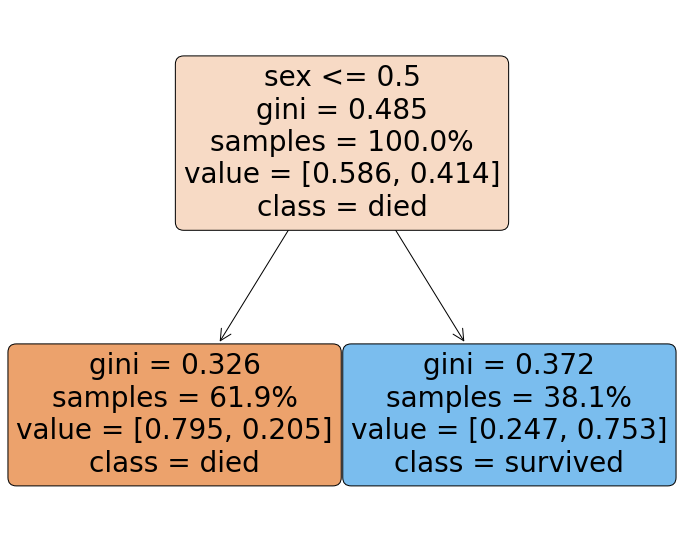

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 10))
plot_tree(
    dt,
    filled=True,
    rounded=True,
    feature_names=features.columns,
    proportion=True,
    class_names=["died", "survived"],
)
plt.show()

The graph encodes classes using colors. Nodes with a majority of samples labeled with “survived” appear in blue and nodes with a majority of samples labeled with “died” in orange. Each node contains the following information.

* gini - the impurity measure at this node
* samples - the percentage of samples in this node
* value - the probabilities for each class
* class - the class with the highest probability

* According to the samples entries in the image from above, there are respectively 61.9% and 38.1% of the samples in the left and right leaves. We can verify that using the value_counts() function from Pandas.

In [9]:
# Proportion of samples by sex
pd.value_counts(data_df.sex, normalize=True)

male      0.619048
female    0.380952
Name: sex, dtype: float64

* The value entries in each leaf indicate the proportion of samples in each class. For instance, the left leaf has 79.5% of samples labeled with “died” and the remaining 20.5% labeled with “survived”. Again, we can verify that using the crosstab() function from Pandas.



In [10]:
# Cross tabulation of sex and survived
crosstab = pd.crosstab(
    index=data_df.sex, columns=data_df.survived, normalize="index"  # Normalize by sex
)
crosstab

survived,0,1
sex,,
female,0.246528,0.753472
male,0.794872,0.205128


The function groups the entries by sex and survival and returns the number of entries in each group, normalized by sex.

The first row corresponds to the probabilities in the right leaf and the second row to the probabilities in the left one. Finally, let’s use these probabilities to verify the Gini impurity values at each leaf.



In [11]:
# Get p(survived) at each leaf
p_left = crosstab.loc["male", 1]
p_right = crosstab.loc["female", 1]

# Compute Gini impurity values
i_left = 2 * p_left * (1 - p_left)
i_right = 2 * p_right * (1 - p_right)
print("Gini impurity (left leaf): {:.3f}".format(i_left))
print("Gini impurity (right leaf): {:.3f}".format(i_right))

Gini impurity (left leaf): 0.326
Gini impurity (right leaf): 0.372


### Deeper trees
Let’s try to increase the depth of the tree to two with the max_depth parameter.

In [12]:
# Create decision tree
dt_2 = DecisionTreeClassifier(criterion="gini", max_depth=2, random_state=0)

# Fit decision tree
dt_2.fit(X, y)

# Get score
dt_2.score(X, y)

0.8108465608465608

The accuracy is around 81% which is a bit better than before. Let’s visualize the new decision tree.



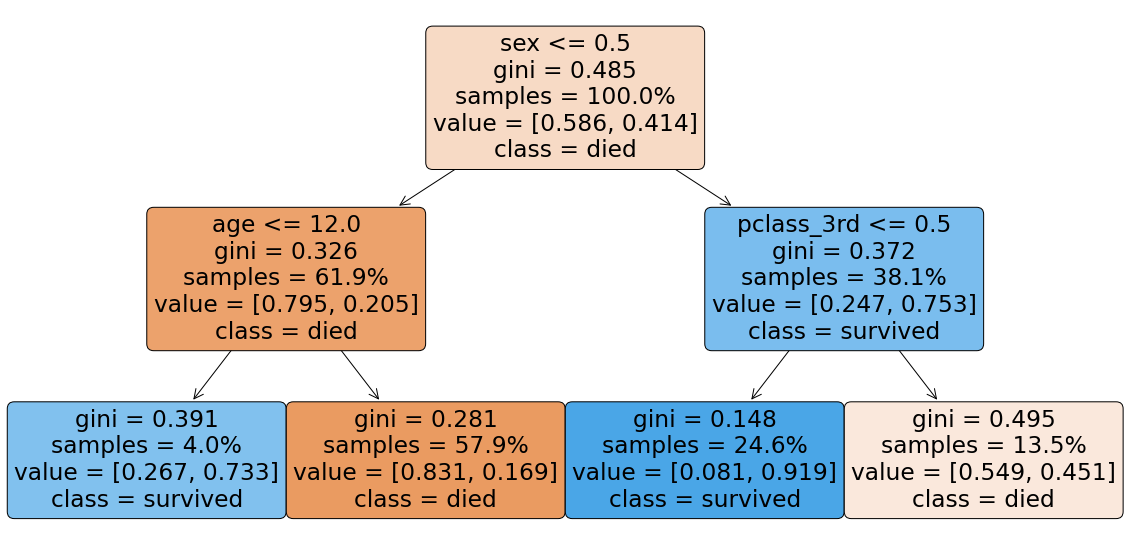

In [14]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    dt_2,
    filled=True,
    rounded=True,
    feature_names=features.columns,
    proportion=True,
    class_names=["died", "survived"],
)
plt.show()

Again, one of the main advantages of the decision tree model is its interpretability. Here is a textual summary of the tree.

Most men perished but young boys survived
Most women survived, but half of the women from the 3rd class perished
However, the complexity of the tree increases with its depth, and it’s easy to create a tree that overfits. For instance, let’s remove the maximum depth criteria by setting it to None. This time, we will fit and evaluate the decision tree on different sets.



In [15]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# Create decision tree
dt_max_depth = DecisionTreeClassifier(criterion="gini", max_depth=None, random_state=0)

# Fit decision tree
dt_max_depth.fit(X_tr, y_tr)

# Get train/test scores
print("Train accuracy: {:.3f}".format(dt_max_depth.score(X_tr, y_tr)))

print("Test accuracy: {:.3f}".format(dt_max_depth.score(X_te, y_te)))

Train accuracy: 0.870
Test accuracy: 0.784


As we can see, the decision tree correctly classifies 87% of the samples from the train set, but only 78.4% from the test set. This is one of the main issues with decision trees. Small trees can be too simple (high bias) to model our data, and larger ones tend to overfit (high variance).

### Summary
In this unit, we saw the basic idea behind decision trees and implemented one using Scikit-learn. Here are a few takeaways.

* Decision trees minimize an impurity measure at each split.
* The complexity of a decision tree depends on its depth.
* Scikit-learn DecisionTreeClassifier estimator requires categorical features to be encoded with one-hot encoding.